In [1]:
from bert import Ner
import pandas as pd
df = pd.read_csv("./z_processed-data.csv")
model = Ner("out_large/")

In [5]:
from nltk import ToktokTokenizer
from nltk.tokenize import sent_tokenize

def sentenced(x):
  entities = []
  count = 0 
  li = sent_tokenize(x)
  for sentence in li:
    if len(sentence) < 512:
      atomised = model.predict(sentence)
      for atoms in atomised :
        if atoms['tag'] != 'O':
          entities.append(atoms)
  return entities

df["entities"] = df["3"].apply(lambda x: sentenced(str(x)))

In [43]:
#start here
df.to_csv('./y_processed_dat.csv')


NameError: name 'df' is not defined

In [1]:
import ast
import pandas as pd
df1 = pd.read_csv("./y_processed_dat.csv")

In [3]:
for k, v in df1["entities"].items():
    a = ast.literal_eval(v)
    name = {'persons': [], 'locations': [], 'orgs': []}
    for atom in a:
        if atom['tag'].startswith('B-PER'):
            name['persons'].append(atom['word'])
        elif atom['tag'].startswith('I-PER'):
            try:
                name['persons'][-1] += " " + atom['word']
            except IndexError:
                name['persons'].append(atom['word'])

        elif atom['tag'].startswith('B-ORG'):
            name['orgs'].append(atom['word'])
        elif atom['tag'].startswith('I-ORG'):
            try:
                name['orgs'][-1] += " " + atom['word']
            except IndexError:
                name['orgs'].append(atom['word'])

        elif atom['tag'].startswith('B-LOC'):
            name['locations'].append(atom['word'])
        elif atom['tag'].startswith('I-LOC'):
            try:
                name['locations'][-1] += " " + atom['word']
            except IndexError:
                name['locations'].append(atom['word'])

    for k1, v1 in name.items():
        df1.at[k,k1]= str(v1)
df1.head(20)

,Unnamed: 0,Unnamed: 0.1,0,1,2,3,secondary_data,entities,persons,locations,orgs
0,0,0,Adzhubei__Aleksei,March_12__1962,Alexei_Adzhubei-s_Account_of_His_Visit_to_Wash...,"TOP SECRETDuring my visit to Washington, Brazi...",TOP SECRETDuring my visit to Washington Brazil...,"[{'word': 'Washington', 'tag': 'B-LOC', 'confi...","['John Kennedy', 'Robert Kennedy', 'João ] Gou...","['Washington', 'Brazil', 'Mexico', 'US', 'Braz...","['International', 'Central Committee', 'Saling..."
1,1,1,Albania__Ministry_of_Foreign_Affairs,March_15__1971,Notes_on_a_Bulletin_of_the_Korean_News_Agency_0,[Handwritten document] Note Looking at the bul...,Handwritten document Note Looking at the bul...,"[{'word': 'Korean', 'tag': 'B-MISC', 'confiden...",[],[],"['5th', 'Congress of the Korean Workers ’ Party']"
2,2,2,Alexandru__Boaba,April_06__1978,TELEGRAM_075_205_from_the_Romanian_Embassy_in_...,NaN,NaN,[],[],[],[]
3,3,3,Anda__Torleiv__1921-,October_21__1976,Telegram_from_the_Embassy_in_Beijing__-Smuggli...,ROYAL MINISTRY OF FOREIGN AFFAIRSCOPY NO:1: MI...,ROYAL MINISTRY OF FOREIGN AFFAIRSCOPY NO:1: MI...,"[{'word': 'POLITICAL', 'tag': 'B-MISC', 'confi...","['Hyeon Jun-geuk', 'Hyun Jun Guk', 'Torleiv', ...","['BEIJINGNR', 'OCTOBER', 'Oslo', 'North Korea'...","['Ministry of Foreign Affairs', 'Ministry of F..."
4,4,4,Anda__Torleiv__1921-,October_22__1976,Telegram_from_Norwegian_Ambassador_to_China_to...,"22.10.76, 09.34 amCOPY NO:1: MINISTER OF FOREI...",221076 0934 amCOPY NO:1: MINISTER OF FOREIGN A...,"[{'word': 'MINISTER', 'tag': 'B-LOC', 'confide...","['UDCINBOUND', 'Keuk', 'Hyeon Jun-geuk', 'Hyon...","['MINISTER', 'BEIJINGNo', 'NORTH KOREA', 'OSLO...",[]
5,5,5,Babkin,April_16__1952,Ciphered_Telegram_No__501587__Babkin_to_Shteme...,[…]CIPHERED TELEGRAM No. 501587From CORRESPOND...,… CIPHERED TELEGRAM No 501587From CORRESPONDE...,"[{'word': '8th', 'tag': 'B-ORG', 'confidence':...",['I.V'],[],"['8th Administration of the General Staff', 'S..."
6,6,6,Badrus__Gheorghe,May_07__1978,Telegram_057_139_from_the_Romanian_Embassy_in_...,NaN,NaN,[],[],[],[]
7,7,7,Badrus__Gheorghe,May_19__1975,Telegram_from_Moscow_to_Bucharest__SECRET__No_...,NaN,NaN,[],[],[],[]
8,8,8,Badrus__Gheorghe,May_19__1975,Telegram_from_Moscow_to_Bucharest__SECRET__No_...,전보문발신자: 모스크바분류: 기밀일자: 1975년 5월 1925일제050.572호조...,전보문발신자: 모스크바분류: 기밀일자: 1975년 5월 1925일제050572호조선...,"[{'word': 'Gheorghe', 'tag': 'B-PER', 'confide...",['Gheorghe Badrus'],[],[]
9,9,9,Bergendahl__Rolf_L_,October_27__1976,Telegram_from_Norwegian_Embassy_in_Tokyo__-Com...,ROYAL NORWEGIAN EMBASSYTOKYO27. OCTOBER 1976NO...,ROYAL NORWEGIAN EMBASSYTOKYO27 OCTOBER 1976NO ...,"[{'word': 'EMBASSYTOKYO27', 'tag': 'B-ORG', 'c...",['Odvar ] Nordli L. BergendahlChargé'],"['OCTOBER', 'NORTH']","['EMBASSYTOKYO27', 'EMBASSY', 'Japan Times']"


In [5]:
def clean_date(date_str):
    try:
        date_arr = date_str.split('_')
        middle_token = '-'
        if len(date_arr) >1 and date_arr[1] != '':
            middle_token = '-' + date_arr[1] + '-'
        new = date_arr[0] + middle_token + date_arr[-1]
    except:
        print(date_str)
        new = ""
    return pd.to_datetime(new,errors='coerce')
df1["time"] = df1["1"].apply(clean_date)
df1.sort_values(by=['time'], inplace=True)
df1

,Unnamed: 0,Unnamed: 0.1,0,1,2,3,secondary_data,entities,persons,locations,orgs,time
577,577,577,Vasilevsky__Aleksandr_Mikhaylovich,August_18__1945,Telegram_from_Aleksandr_Vasilevsky_to_Stalin_0,18.8.45Moscow. Personally to Cde. StalinCopy: ...,18845Moscow Personally to Cde StalinCopy: pers...,"[{'word': 'Cde', 'tag': 'B-ORG', 'confidence':...","['Ksenofonov', 'Kuznetsov']","['Far East', 'Changchun', 'Mukden', 'Shenyang'...","['Cde', 'StalinCopy', 'Cde', 'Bulganin', 'Anto...",1945-08-18
578,578,578,Vasilevsky__Aleksandr_Mikhaylovich,August_20__1945,Cable_from_Aleksandr_Vasilevsky_to_Stalin_0,Moscow. Cde. StalinCopy: General Staff Cde. An...,Moscow Cde StalinCopy: General Staff Cde Anton...,"[{'word': 'Moscow', 'tag': 'B-LOC', 'confidenc...","['Hata', 'Hata', 'Hata', 'Hata', 'Hata', 'Hata...","['Moscow', 'Far', 'Manchuria', 'Changchun', 'M...","['Cde', 'General Staff Cde', 'AntonovReporting...",1945-08-20
485,485,485,Shtykov__Terentiĭ_Fomich__1907-1964,May_12__1947,Cable_No__121973__Meretskov_and_Shytkov_to_Cde...,[handwritten at the top: to Cde. StalinI think...,handwritten at the top: to Cde StalinI think ...,"[{'word': 'Cde', 'tag': 'B-ORG', 'confidence':...","['I. Stalin', 'Rodina']","['North Korea', 'North Korea', 'North Korea', ...","['Cde', 'StalinI', 'Molotov', 'MOSCOW VKP', 'C...",1947-05-12
204,204,204,Malik__G__J_,October_12__1947,Incoming_Cable_No__16__Malik_to_Cde__Stalin_0,STRICTLY SECRET CABLEFrom Moscow sent at 0350 ...,STRICTLY SECRET CABLEFrom Moscow sent at 0350 ...,"[{'word': 'CABLEFrom', 'tag': 'B-LOC', 'confid...","['Cde', 'Stalin', 'Cde Malik', 'Cde Molotov', ...","['CABLEFrom', 'Moscow', 'Sochi Korea']","['People ’ s Committee of North Korea', 'Korea...",1947-10-12
269,269,269,Molotov__Vyacheslav_Mikhaylovich__1890-1986,October_18__1947,Ciphered_Telegram__Molotov_to_Cde__Stalin_0,3RD UNIT\t\t\t\t\t\t\t\t\t CopyTop Se...,3RD UNIT\t\t\t\t\t\t\t\t\t CopyTop Se...,"[{'word': 'UNIT', 'tag': 'B-ORG', 'confidence'...","['CIPHERSOUTH', 'Vyshinsky', 'Marshall', 'Mars...","['Korea', 'US', 'USSR', 'Korea', 'United State...","['UNIT', 'Cde', 'Assembly', 'MOLOTOV18', 'Cde'...",1947-10-18
...,...,...,...,...,...,...,...,...,...,...,...,...
277,277,277,Méray__Tibor,June__2000,Tibor_Méray__-Germ_Warfare__Memories_and_Refle...,Tibor Méray:Germ WarfareMemories and Reflectio...,Tibor Méray:Germ WarfareMemories and Reflectio...,"[{'word': 'Tibor', 'tag': 'B-PER', 'confidence...","['Tibor Méray', 'Winston Churchill', 'Kathryn ...","['Korea', 'Kaesong', 'Czechoslovakia', 'Korea'...","['Budapest University', 'Communist Party', 'Sz...",2000-06-01
202,202,202,Luo__Guibo__1907-1995,1992,A_Glorious_Model_of_Proletarian_Internationali...,"OneLate in 1949, soon after the establishment ...",OneLate in 1949 soon after the establishment o...,"[{'word': 'OneLate', 'tag': 'B-ORG', 'confiden...","['Ho Chi Minh', 'Mao', 'Ho', 'Hoʼs', 'Mao', 'L...","['Beijing', 'Chinaʼs', 'Vietnamʼs', 'France.Fo...","['OneLate', 'New China', 'Central Committee of...",NaT
581,581,581,Vassiliev__Alexander,2009,Vassiliev_White_Notebook_#2_0,NaN,NaN,[],[],[],[],NaT
582,582,582,Vassiliev__Alexander,2009,Vassiliev_White_Notebook_#3_0,NaN,NaN,[],[],[],[],NaT


In [40]:
!pip install thefuzz[speedup]

     |████████████████████████████████| 50 kB 4.7 MB/s             
  Preparing metadata (setup.py) ... done
  Created wheel for python-levenshtein: filename=python_Levenshtein-0.12.2-cp39-cp39-linux_x86_64.whl size=172236 sha256=016c33fd0dc5fca0524877c417142daf1dc742077ef6e520b77be75d5e57ad50
  Stored in directory: /home/ksatrayamaii/.cache/pip/wheels/46/4a/6c/164a1d9dd67c82d208f19d869ad0a517a0c5a6117f608c53e6
Successfully built python-levenshtein


In [90]:
import numpy as np

def boolean_df(dataframe, org_chart):# Create empty dict
    bool_dict = {}
    count = 0
    dataframe1= {}
    # Loop through all the tags
    for i, item in org_chart.items():
        #print(item)
        # Apply boolean mask
        dataframe1[i] = dataframe["persons"].apply(lambda x: x.count(i))
        #implement fuzzywuzzy search here to spot all of the entities 
        count +=1
            
    # Return the results as a dataframe
    return pd.DataFrame(dataframe1)

from thefuzz import process

def giffme(name, ls):
    count = 0 
    for x in process.extract(name, ls, limit = 5):
        if x[1] >90:
            count += 1
    if count ==0:
        return np.nan
    return count
            
    
    

In [91]:
org_chart = pd.read_csv("./merged_political_military.csv") ## update org_chart name list to extract more major names
org_chart.head()
org_dict = org_chart[['itemLabel', 'politicalPartyLabel']].set_index('itemLabel').to_dict()
df2 = boolean_df(df1, org_dict['politicalPartyLabel'])
df1= df1.sort_index()
df2 = df2.sort_index()

In [92]:
path = "../z2_processed_data_with_orgs.csv"
df_orgs = pd.read_csv(path, index_col=0)
def clean_date(date_str):
    try:
        date_arr = date_str.split('_')
        middle_token = '-'
        if len(date_arr) >1 and date_arr[1] != '':
            middle_token = '-' + date_arr[1] + '-'
        new = date_arr[0] + middle_token + date_arr[-1]
    except:
        print(date_str)
        new = ""
    return pd.to_datetime(new,errors='coerce')
df_orgs["time"] = df_orgs["1"].apply(clean_date)
df2["sentiment"] = df_orgs["sentiment"] 
df2["time"] = df_orgs["time"]

In [96]:
nunique = df2.nunique()
cols_to_drop = nunique[nunique == 1].index # drop where theres no value other than same 0
df2.drop(cols_to_drop, axis=1)
df2.to_csv('../telegram_fellas_no_fuzzy.csv')
df2

,Liu Shaoqi,Soong Ching-ling,Zhu De,Zhou Enlai,Mao Zedong,Chen Yi,Xie Fuzhi,Kim Il-sung,Jiang Qing,Lin Biao,...,Vladimir Drozdov,"Nikolaev, Andrey Semyonovich",Vladimir Ivanov,Aleksey Shchelakovskiy,Michail Michailovič Dagajev,Nikolay Dedayev,Maxim Chibisov,Konstantin Zhuravlyov,sentiment,time
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1962-03-12
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1971-03-15
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1978-04-06
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1976-10-21
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1976-10-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1971-09-24
776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1982-09-24
777,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1980-09-25
778,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1964-09-27


<AxesSubplot:xlabel='time'>

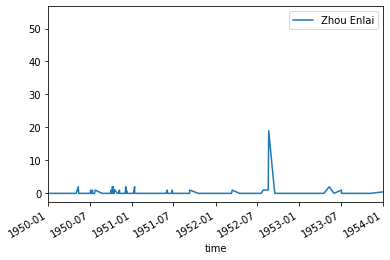

In [97]:
cols = list(df2)[0:30]
#df2.plot(x="time", y=cols, xlim=(pd.to_datetime('01-01-1950'), pd.to_datetime('01-01-1954')),)
df2.plot(x="time", y ="Kim Il-sung", xlim=(pd.to_datetime('01-01-1950'), pd.to_datetime('01-01-1954')))